In [4]:
!pip -q install lightgbm

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import lightgbm as lgb

rng = np.random.default_rng(42)

# ==== 1) データ生成（あなたの記憶ベース） ====
N = 3000
prefectures = [
    "北海道","青森県","岩手県","宮城県","秋田県","山形県","福島県",
    "茨城県","栃木県","群馬県","埼玉県","千葉県","東京都","神奈川県",
    "新潟県","富山県","石川県","福井県","山梨県","長野県",
    "岐阜県","静岡県","愛知県","三重県",
    "滋賀県","京都府","大阪府","兵庫県","奈良県","和歌山県",
    "鳥取県","島根県","岡山県","広島県","山口県",
    "徳島県","香川県","愛媛県","高知県",
    "福岡県","佐賀県","長崎県","熊本県","大分県","宮崎県","鹿児島県","沖縄県"
]
def make_city_names(pref):
    bases = ["中央","北","南","東","西","港","緑","桜"]
    return [f"{pref}-{b}市" for b in bases]
pref_to_cities = {p: make_city_names(p) for p in prefectures}
branches = [f"支店_{i:03d}" for i in range(1, 121)]

age = np.clip(rng.normal(loc=45, scale=15, size=N).round().astype(int), 18, 85)

def make_balances(n, mean_log=11.0, sigma_log=1.0, zero_rate=0.15):
    bal = rng.lognormal(mean=mean_log, sigma=sigma_log, size=n) / 1000.0
    mask_zero = rng.random(n) < zero_rate
    bal[mask_zero] = 0.0
    return np.clip(bal, 0, 1.5e7)

BAL1 = make_balances(N, mean_log=10.5, sigma_log=1.0, zero_rate=0.25)
BAL2 = make_balances(N, mean_log=10.8, sigma_log=0.9, zero_rate=0.20)
BAL3 = make_balances(N, mean_log=10.3, sigma_log=1.1, zero_rate=0.30)
BAL4 = make_balances(N, mean_log=10.0, sigma_log=1.0, zero_rate=0.35)
BAL5 = make_balances(N, mean_log=11.2, sigma_log=0.8, zero_rate=0.10)

gender = rng.choice(["男","女"], size=N, p=[0.52, 0.48])
household_head = (rng.random(N) < (0.3 + 0.35*(age>=30))).astype(int)

def bernoulli(p):
    return (rng.random(N) < p).astype(int)

payroll_dep = bernoulli(0.65 * ((age>=23)&(age<=65)) + 0.05*(age<23) + 0.10*(age>65))
pension_recv = bernoulli(0.60*(age>=65) + 0.05*(age<65))
water_pay = bernoulli(0.55)
nhk_pay = bernoulli(0.50)
phone_pay = bernoulli(0.70)
insurance_pay = bernoulli(0.45)

pref = rng.choice(prefectures, size=N)
city = np.array([rng.choice(pref_to_cities[p]) for p in pref])
branch = rng.choice(branches, size=N)

pref_bias_map = {p: b for p, b in zip(prefectures, rng.normal(0, 0.3, size=len(prefectures)))}
pref_bias = np.array([pref_bias_map[p] for p in pref])

balances_sum = (BAL1 + BAL2 + BAL3 + BAL4 + BAL5) / 1e6
num_auto_pays = water_pay + nhk_pay + phone_pay + insurance_pay

lin = (
    -0.4
    + 0.18*(balances_sum**0.5)
    + 0.35*payroll_dep
    + 0.25*household_head
    + 0.08*num_auto_pays
    + 0.30*pension_recv*(age>=65)
    + 0.10*(gender=="女")
    + 0.12*((age>=25)&(age<=45))
    + 0.05*((age>65))
    + 0.10*pref_bias
)

def calibrate_intercept(lin, target_rate=0.30, tol=1e-4, max_iter=100):
    lo, hi = -10.0, 10.0
    for _ in range(max_iter):
        mid = (lo+hi)/2
        prob = 1/(1+np.exp(-(lin+mid)))
        rate = prob.mean()
        if abs(rate - target_rate) < tol:
            return mid
        if rate < target_rate:
            lo = mid
        else:
            hi = mid
    return mid

offset = calibrate_intercept(lin, target_rate=0.30)
prob = 1/(1+np.exp(-(lin+offset)))
TARGET_FRG = (rng.random(N) < prob).astype(int)

df = pd.DataFrame({
    "ID": np.arange(1, N+1),
    "AGE": age,
    "BAL1": (BAL1/100).round(2),
    "BAL2": (BAL2/100).round(2),
    "BAL3": (BAL3/100).round(2),
    "BAL4": (BAL4/100).round(2),
    "BAL5": (BAL5/100).round(2),
    "GENDER": gender,
    "HOUSEHOLD_HEAD": household_head,
    "PAYROLL_DEP": payroll_dep,
    "PENSION_RECV": pension_recv,
    "WATER_PAY": water_pay,
    "NHK_PAY": nhk_pay,
    "PHONE_PAY": phone_pay,
    "INSURANCE_PAY": insurance_pay,
    "PREFECTURE": pref,
    "CITY": city,
    "BRANCH": branch,
    "TARGET_FRG": TARGET_FRG
})
print(df.shape, "positive rate:", df["TARGET_FRG"].mean())

(3000, 19) positive rate: 0.29233333333333333


In [6]:
df.head()

,ID,AGE,BAL1,BAL2,BAL3,BAL4,BAL5,GENDER,HOUSEHOLD_HEAD,PAYROLL_DEP,PENSION_RECV,WATER_PAY,NHK_PAY,PHONE_PAY,INSURANCE_PAY,PREFECTURE,CITY,BRANCH,TARGET_FRG
0,1,50,1.27,2.09,0.20,0.14,0.00,男,0,0,0,1,0,1,1,岡山県,岡山県-東市,支店_058,0
1,2,29,0.72,1.27,0.30,0.07,0.32,男,0,0,0,1,1,1,0,秋田県,秋田県-北市,支店_049,0
2,3,56,2.59,0.11,0.00,0.15,0.29,女,1,1,0,0,1,0,1,山梨県,山梨県-中央市,支店_003,0
3,4,59,0.08,1.65,0.72,0.00,0.75,男,0,1,0,1,0,1,1,大分県,大分県-西市,支店_041,1
4,5,18,0.28,1.65,0.00,0.29,0.56,男,1,0,0,0,0,0,0,奈良県,奈良県-中央市,支店_009,0


In [20]:
df['GENDER'] = df['GENDER'].map({'男': 0, '女': 1})

In [8]:
# ==== 2) 前処理（カテゴリ列の指定） ====
categorical_cols = ["GENDER","HOUSEHOLD_HEAD","PAYROLL_DEP","PENSION_RECV",
                    "WATER_PAY","NHK_PAY","PHONE_PAY","INSURANCE_PAY",
                    "PREFECTURE","CITY","BRANCH"]
numeric_cols = ["AGE","BAL1","BAL2","BAL3","BAL4","BAL5"]

for c in categorical_cols:
    df[c] = df[c].astype("category")

# ==== 3) 学習/検証分割 ====
target_col = "TARGET_FRG"
X = df[categorical_cols + numeric_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== 4) LightGBM 学習 ====
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbosity": -1
}

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, free_raw_data=False)

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

# ==== 5) 評価 ====
proba = model.predict(X_val, num_boost_round=model.best_iteration)
pred = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_val, pred),
    "precision": precision_score(y_val, pred),
    "recall": recall_score(y_val, pred),
    "f1": f1_score(y_val, pred),
    "roc_auc": roc_auc_score(y_val, proba),
    "pr_auc": average_precision_score(y_val, proba),
}
for k,v in metrics.items():
    print(f"{k:>9}: {v:.4f}")

# 重要度（参考）
imp = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False)
imp.head(20)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.905363	valid's auc: 0.513183
 accuracy: 0.6983
precision: 0.3500
   recall: 0.0400
       f1: 0.0718
  roc_auc: 0.5132
   pr_auc: 0.3125


,feature,importance
10,BRANCH,1121.105100
8,PREFECTURE,833.191926
13,BAL2,746.760792
14,BAL3,653.103459
16,BAL5,650.863539
12,BAL1,555.333498
11,AGE,541.788888
1,HOUSEHOLD_HEAD,348.565189
15,BAL4,337.660711
2,PAYROLL_DEP,131.899441


## 可視化テンプレート

In [9]:
# ===== 0. 必要ライブラリ =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font="IPAexGothic")  # 日本語対応（IPAexフォント）

In [11]:
# ===== 1. 基本情報の確認 =====
def basic_info(df):
    print("=== データ概要 ===")
    print(df.shape)
    print("\n=== カラムごとの型 ===")
    print(df.dtypes)
    print("\n=== 欠損値数 ===")
    print(df.isnull().sum())
    print("\n=== 数値変数の基本統計量 ===")
    display(df.describe())
    print("\n=== カテゴリ変数の基本統計量 ===")
    display(df.describe(include=["object", "category"]))

# ===== 2. 数値変数の分布とTARGET別比較 =====
def plot_numeric_distribution(df, num_col, target_col):
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df, x=num_col, hue=target_col, common_norm=False, fill=True)
    plt.title(f"{num_col} 分布（by {target_col}）")
    plt.show()

    plt.figure(figsize=(6,5))
    sns.boxplot(x=target_col, y=num_col, data=df)
    plt.title(f"{num_col} vs {target_col}（箱ひげ図）")
    plt.show()

# ===== 3. カテゴリ変数のTARGET別割合比較 =====
def plot_categorical_rate(df, cat_col, target_col):
    rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=cat_col, y=target_col, data=rate_df, order=rate_df.sort_values(target_col, ascending=False)[cat_col])
    plt.xticks(rotation=45)
    plt.title(f"{cat_col}別 {target_col}率")
    plt.show()

    plt.figure(figsize=(8,5))
    sns.countplot(x=cat_col, hue=target_col, data=df)
    plt.xticks(rotation=45)
    plt.title(f"{cat_col}別 件数（by {target_col}）")
    plt.show()

# ===== 4. クロス集計のヒートマップ =====
def plot_crosstab_heatmap(df, col1, col2, target_col):
    ct = pd.crosstab(df[col1], df[col2], values=df[target_col], aggfunc="mean")
    plt.figure(figsize=(10,6))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{col1}×{col2} 別 {target_col}率")
    plt.show()

# ===== 5. 相関ヒートマップ（数値変数のみ） =====
def plot_corr_heatmap(df, numeric_cols):
    plt.figure(figsize=(10,8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("数値変数の相関")
    plt.show()

=== データ概要 ===
(3000, 19)

=== カラムごとの型 ===
ID                   int64
AGE                  int64
BAL1               float64
BAL2               float64
BAL3               float64
BAL4               float64
BAL5               float64
GENDER            category
HOUSEHOLD_HEAD    category
PAYROLL_DEP       category
PENSION_RECV      category
WATER_PAY         category
NHK_PAY           category
PHONE_PAY         category
INSURANCE_PAY     category
PREFECTURE        category
CITY              category
BRANCH            category
TARGET_FRG           int64
dtype: object

=== 欠損値数 ===
ID                0
AGE               0
BAL1              0
BAL2              0
BAL3              0
BAL4              0
BAL5              0
GENDER            0
HOUSEHOLD_HEAD    0
PAYROLL_DEP       0
PENSION_RECV      0
WATER_PAY         0
NHK_PAY           0
PHONE_PAY         0
INSURANCE_PAY     0
PREFECTURE        0
CITY              0
BRANCH            0
TARGET_FRG        0
dtype: int64

=== 数値変数の基本統計量 ===


,ID,AGE,BAL1,BAL2,BAL3,BAL4,BAL5,TARGET_FRG
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,44.857333,0.475333,0.606107,0.385460,0.235950,0.916693,0.292333
std,866.169729,14.545910,0.793214,0.909471,0.664922,0.393184,0.992755,0.454910
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,35.000000,0.040000,0.120000,0.000000,0.000000,0.330000,0.000000
50%,1500.500000,45.000000,0.250000,0.360000,0.170000,0.110000,0.650000,0.000000
75%,2250.250000,55.000000,0.570000,0.750000,0.460000,0.300000,1.160000,1.000000
max,3000.000000,85.000000,11.490000,20.560000,9.590000,4.470000,13.920000,1.000000



=== カテゴリ変数の基本統計量 ===


,GENDER,HOUSEHOLD_HEAD,PAYROLL_DEP,PENSION_RECV,WATER_PAY,NHK_PAY,PHONE_PAY,INSURANCE_PAY,PREFECTURE,CITY,BRANCH
count,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000
unique,2,2,2,2,2,2,2,2,47,376,120
top,男,1,1,0,1,0,1,0,東京都,奈良県-桜市,支店_010
freq,1571,1771,1630,2696,1664,1513,2124,1634,78,19,37


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


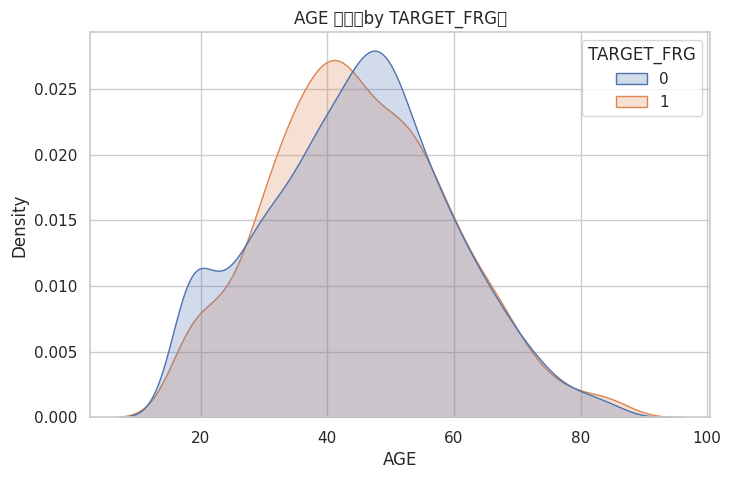

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

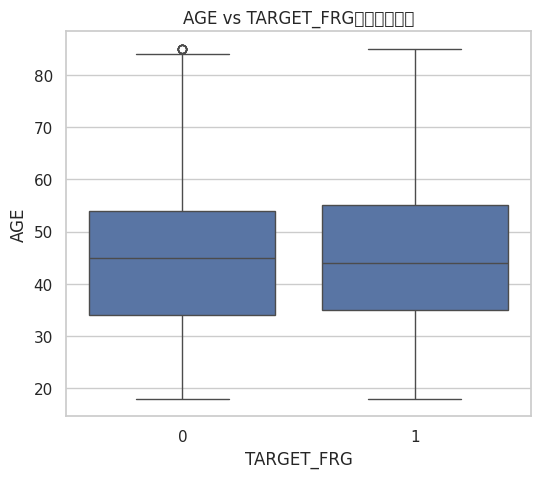

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


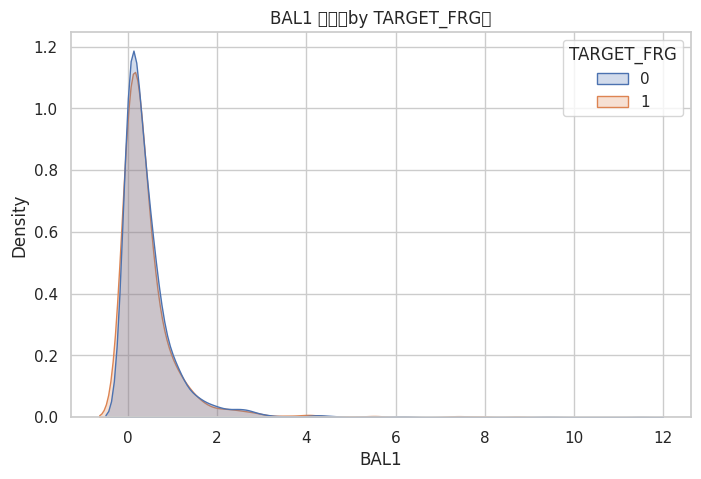

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

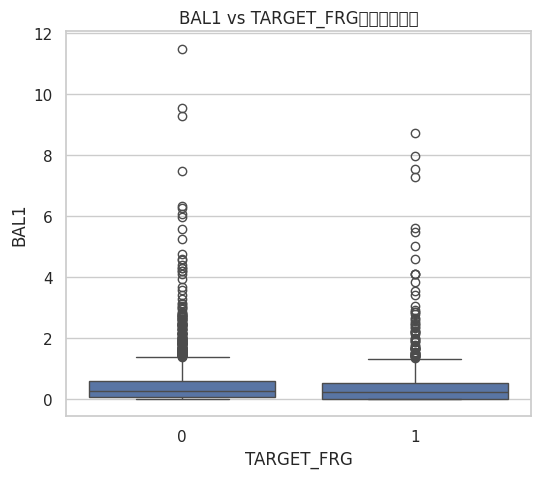

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


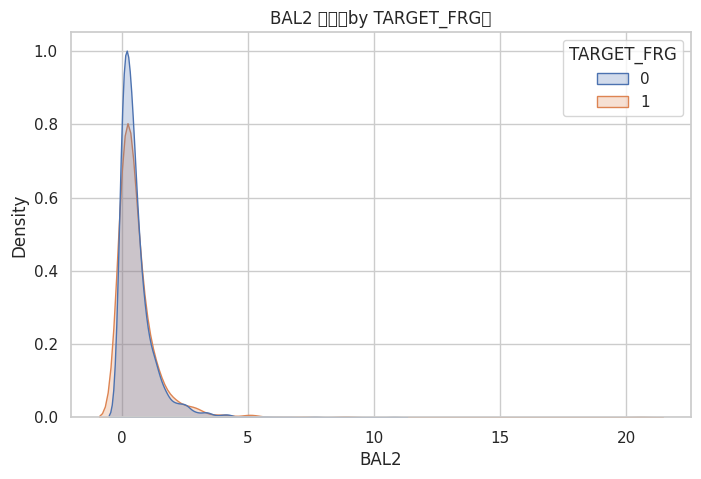

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

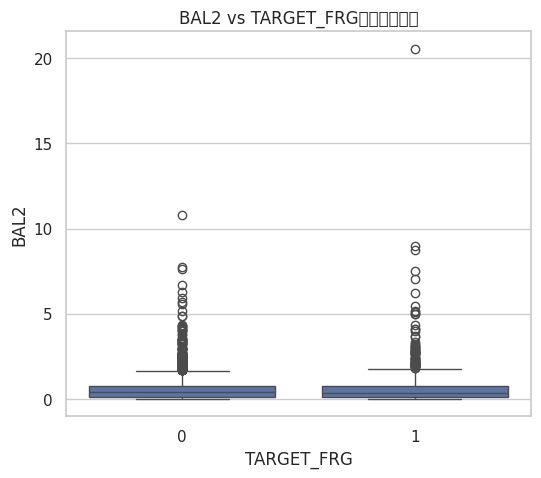

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


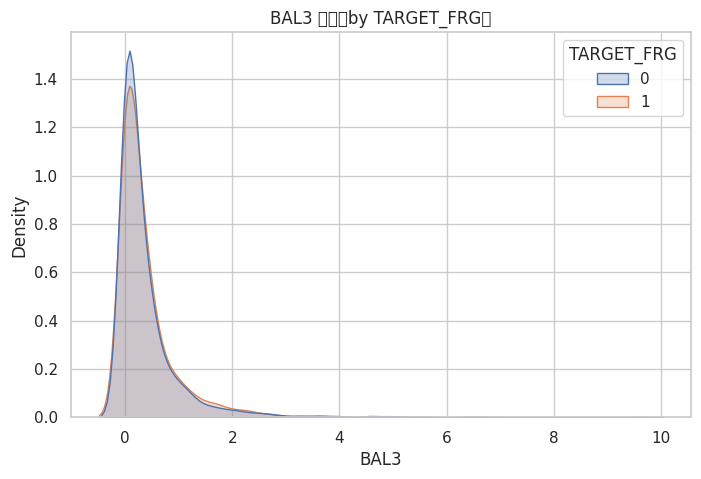

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

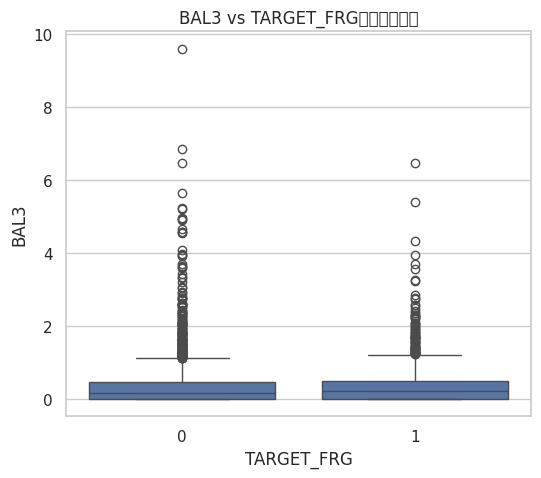

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


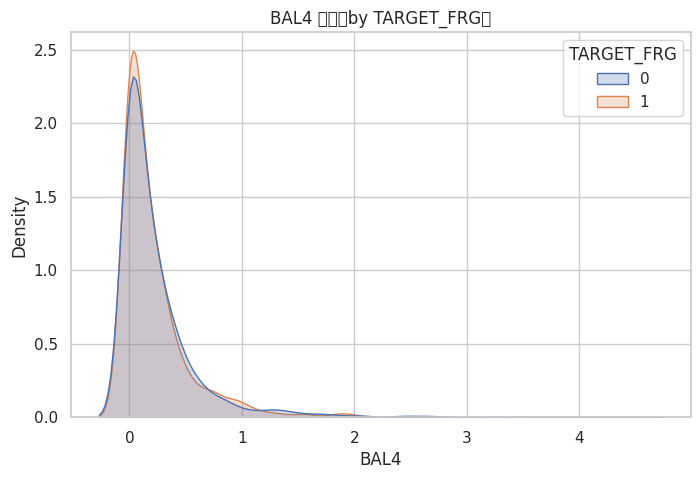

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

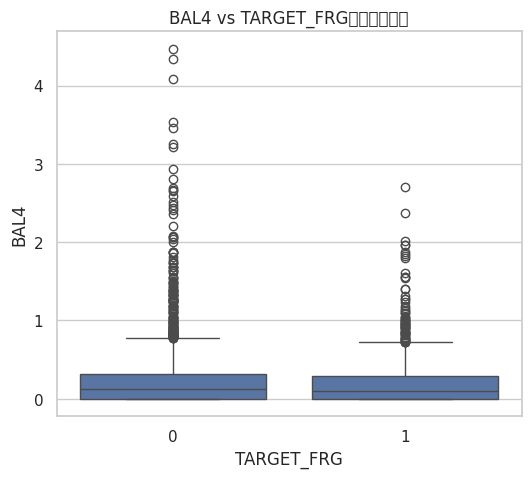

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


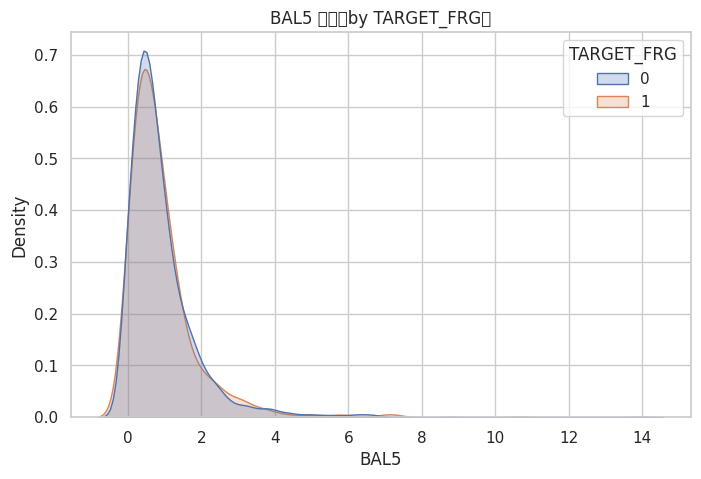

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

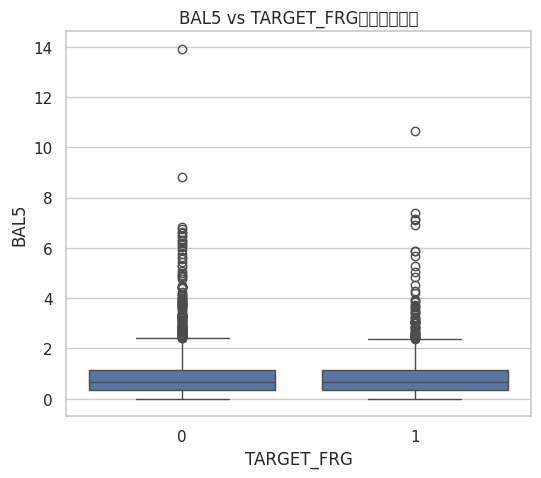

In [13]:
# ==== データ読み込み ====
# df = pd.read_csv("your_data.csv")  # インターンPCで読み込み

target_col = "TARGET_FRG"
numeric_cols = ["AGE", "BAL1", "BAL2", "BAL3", "BAL4", "BAL5"]
categorical_cols = ["GENDER", "HOUSEHOLD_HEAD", "PAYROLL_DEP", "PENSION_RECV",
                    "WATER_PAY", "NHK_PAY", "PHONE_PAY", "INSURANCE_PAY",
                    "PREFECTURE", "CITY", "BRANCH"]

# ==== 基本情報確認 ====
basic_info(df)

# ==== 数値変数のEDA ====
for col in numeric_cols:
    plot_numeric_distribution(df, col, target_col)


/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPyt

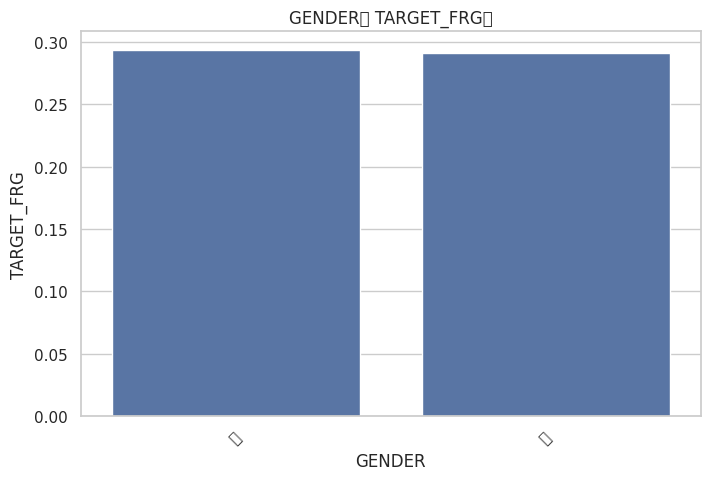

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

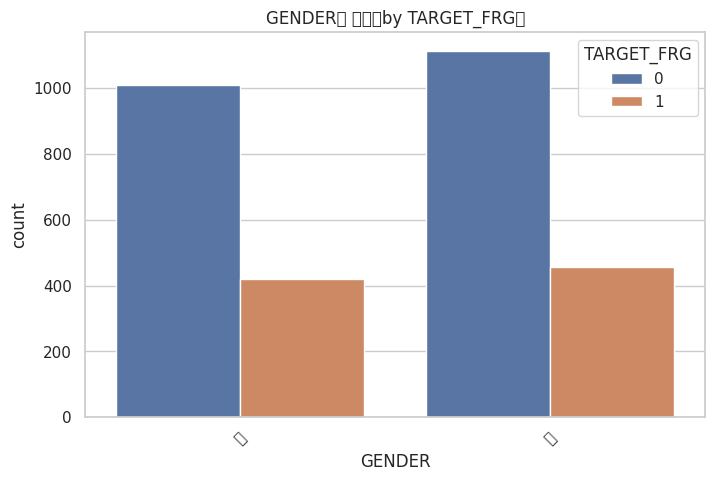

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


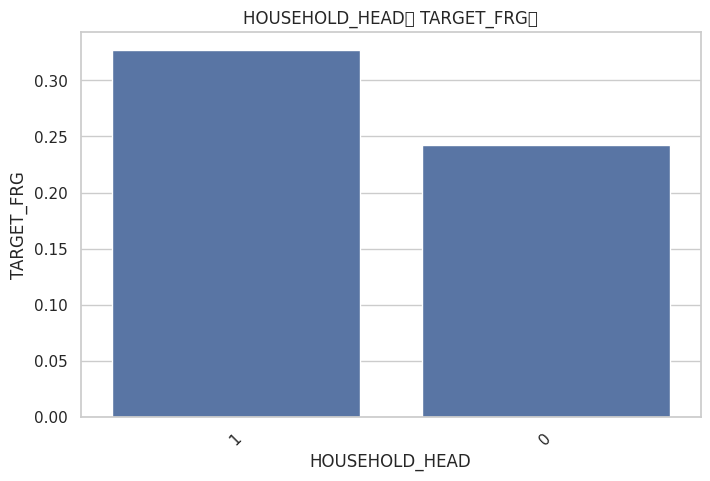

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

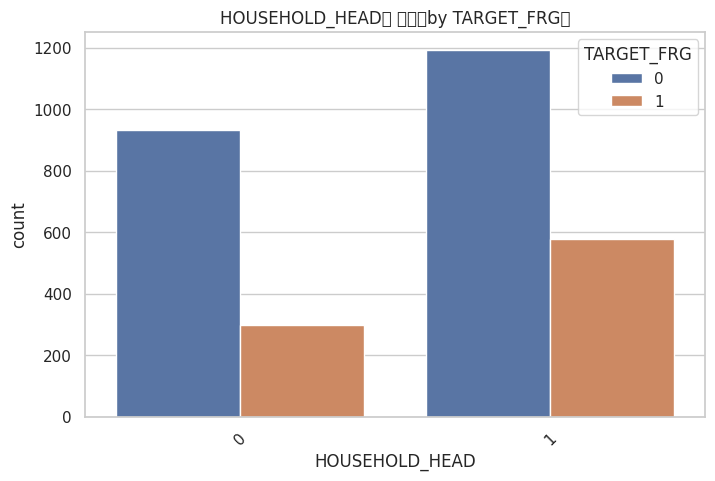

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


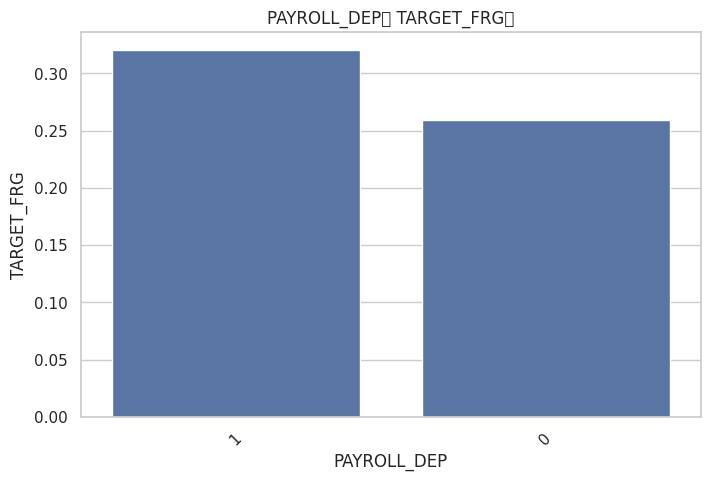

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

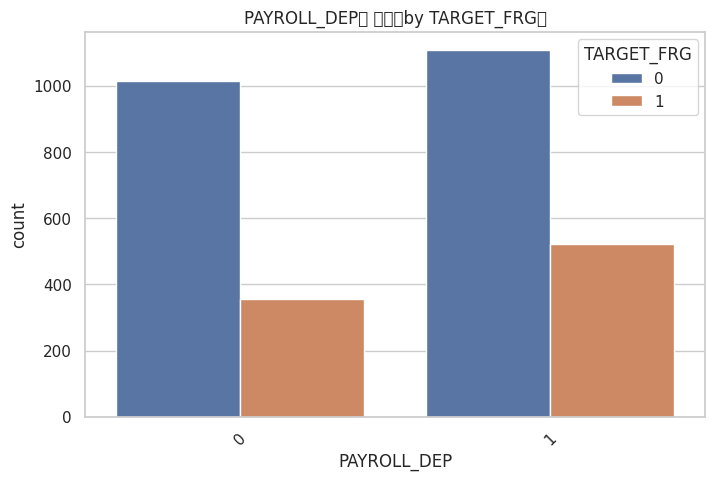

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


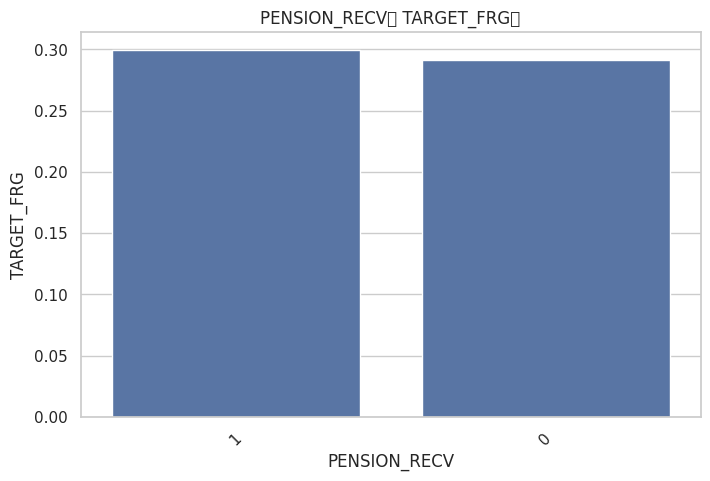

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

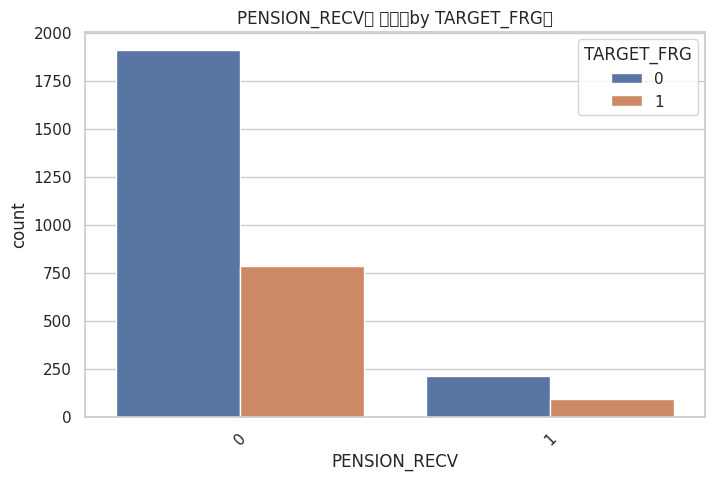

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


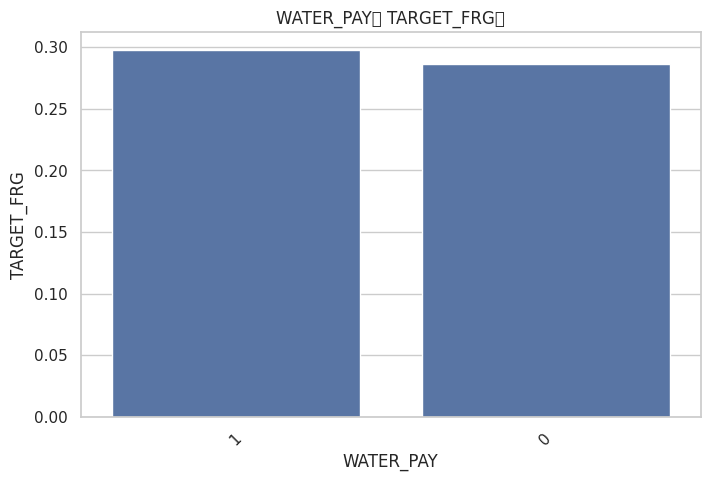

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

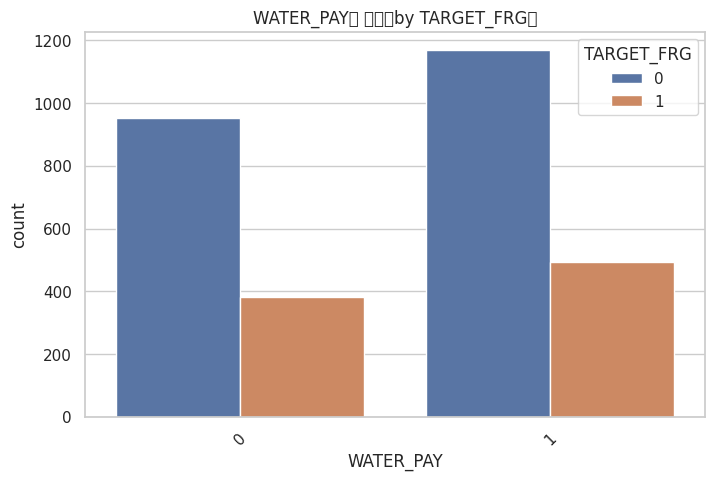

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


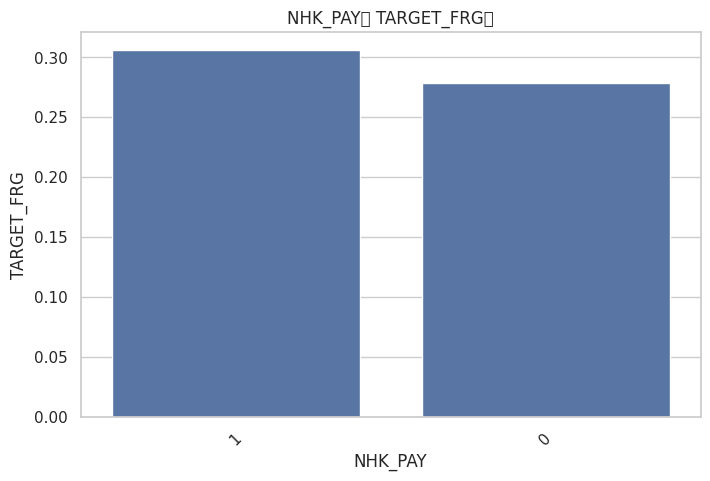

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

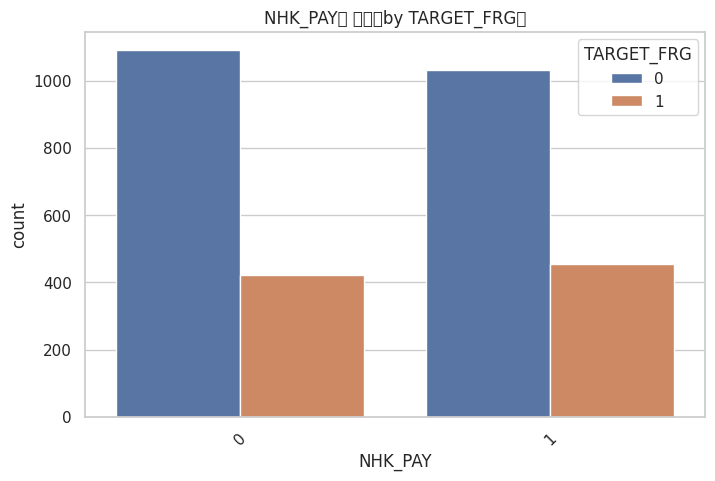

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


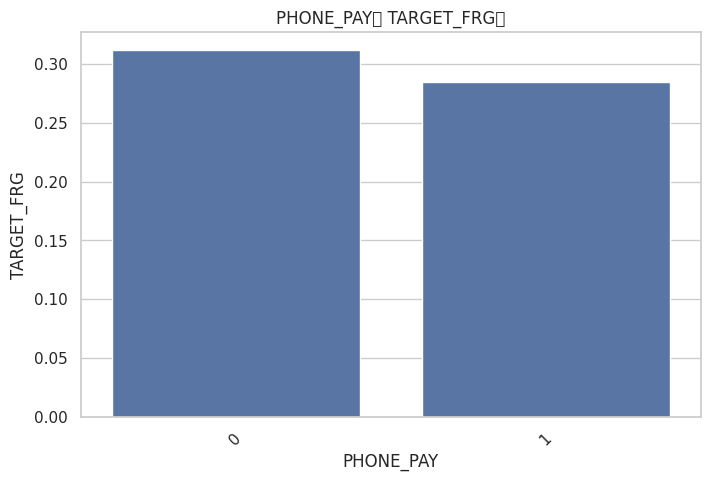

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

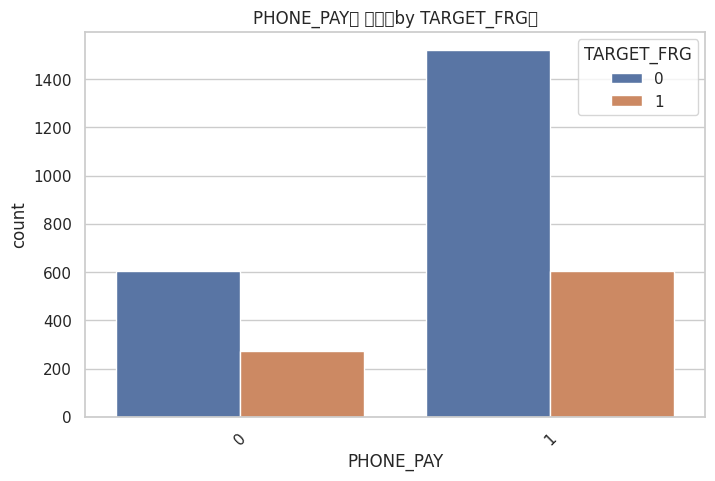

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


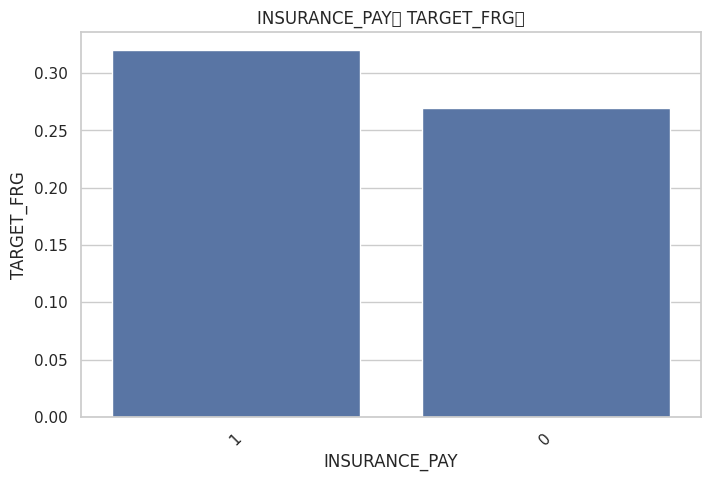

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

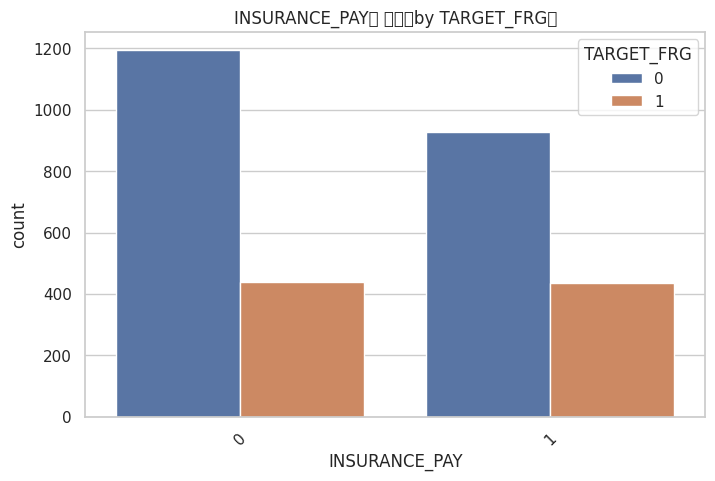

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23721 (\N{CJK UNIFIED IDEOGRAPH-5CA9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPyt

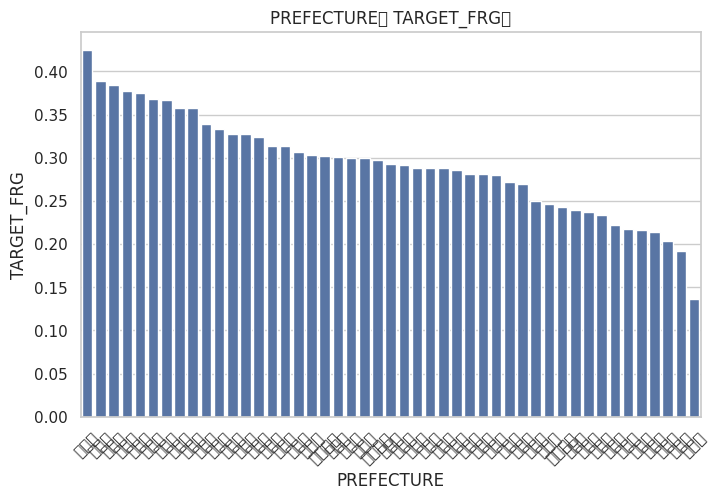

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

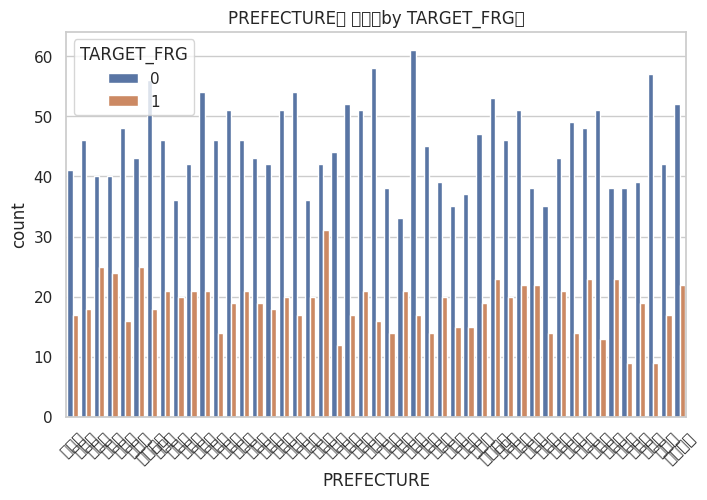

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPyt

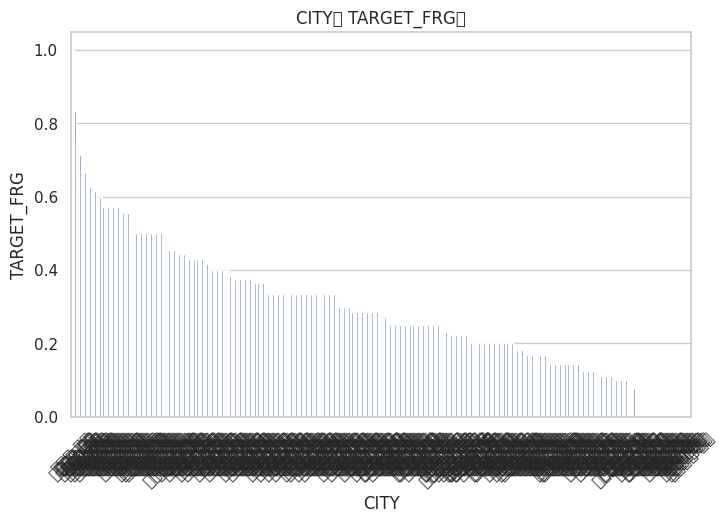

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

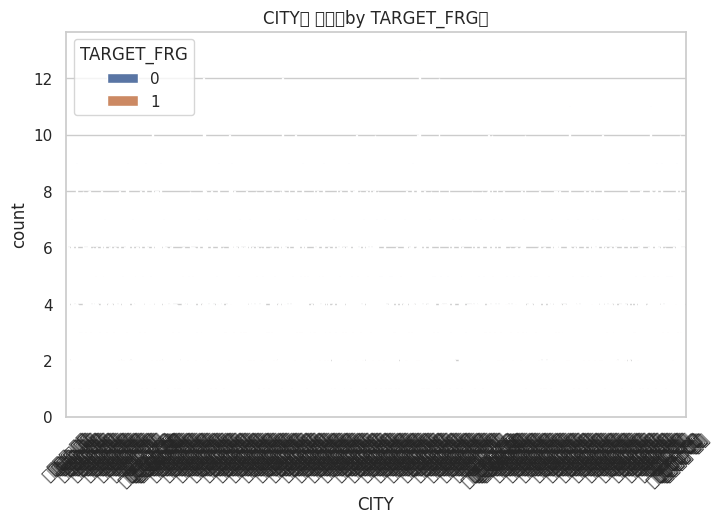

/tmp/ipython-input-3582820008.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_df = df.groupby(cat_col)[target_col].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25903 (\N{CJK UNIFIED IDEOGRAPH-652F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPyt

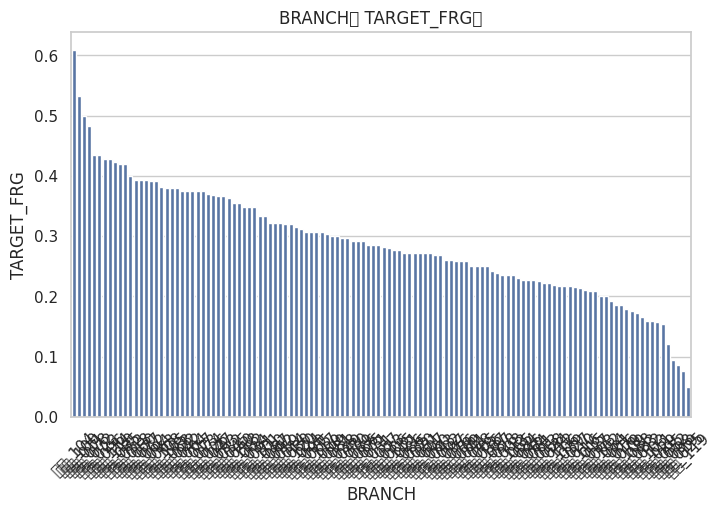

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canva

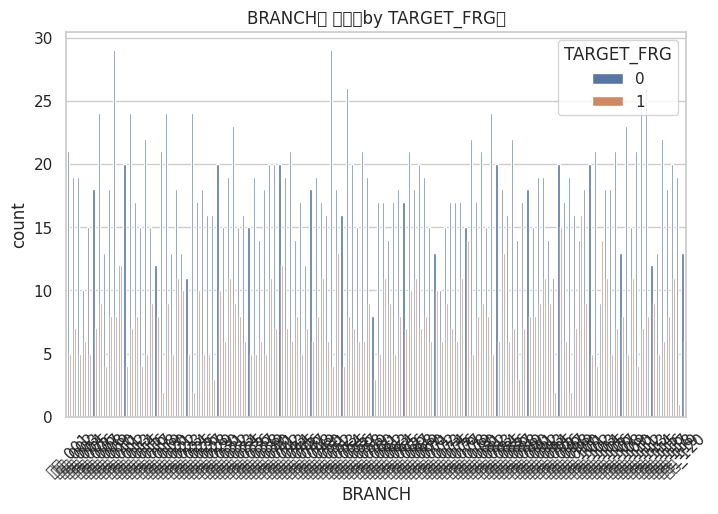

In [14]:
# ==== カテゴリ変数のEDA ====
for col in categorical_cols:
    plot_categorical_rate(df, col, target_col)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 30007 (\N{CJK UNIFIED IDEOGRAPH-7537}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packa

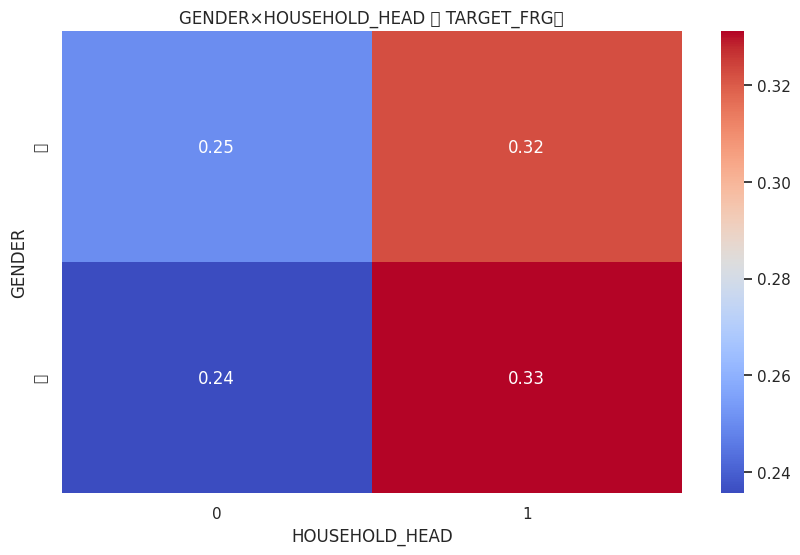

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 30476 (\N{CJK UNIFIED IDEOGRAPH-770C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20304 (\N{CJK UNIFIED IDEOGRAPH-4F50}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36032 (\N{CJK UNIFIED IDEOGRAPH-8CC0}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from fon

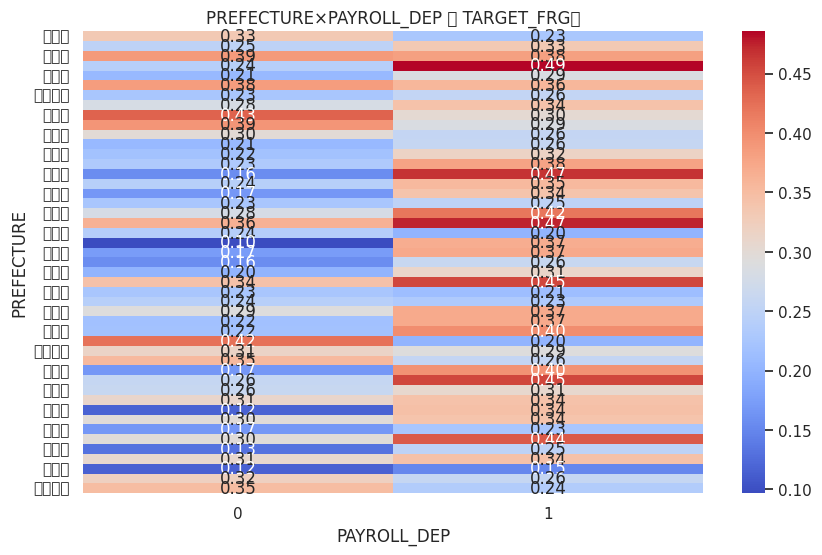

In [15]:
# ==== クロス集計例 ====
plot_crosstab_heatmap(df, "GENDER", "HOUSEHOLD_HEAD", target_col)
plot_crosstab_heatmap(df, "PREFECTURE", "PAYROLL_DEP", target_col)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

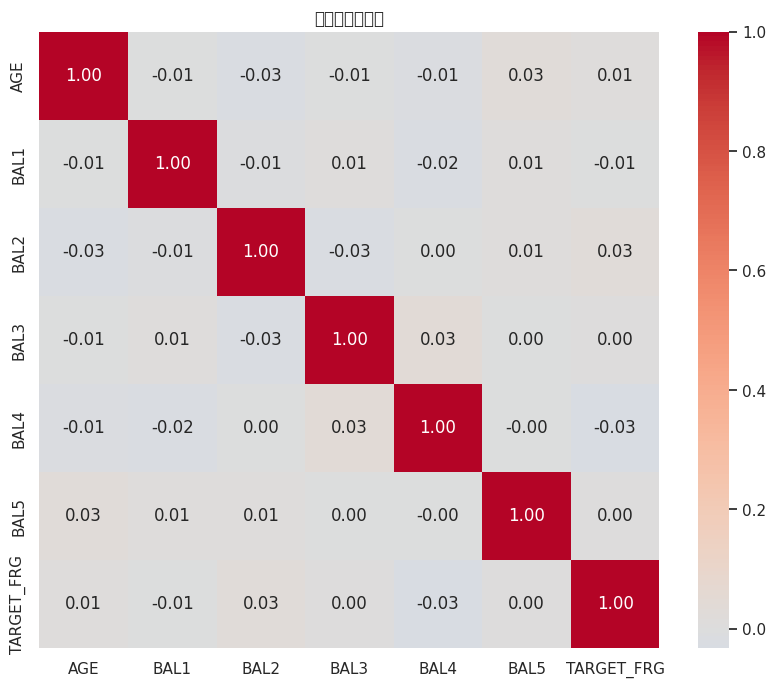

In [17]:
# ==== 相関分析 ====
plot_corr_heatmap(df, numeric_cols + [target_col])

なるほど、今回の仮説は7つの観点があり、どれもOlive開設率（`TARGET_FRG`）との関係を定量的・可視的に検証できそうです。
以下では、**あなたの仮説を検証するための手順**を、明日のインターンでそのまま使えるように整理します。

---

## 0. 事前準備

* **目的変数**: `TARGET_FRG`
* **EDAテンプレート**: 先ほどの可視化関数を利用
* **変数型の確認と前処理**

  * 欠損値の補完（職種など）
  * 数値型・カテゴリ型の適切な型変換（カテゴリは`category`型）

---

## 1. 仮説①：アプリ利用頻度 × 年齢

**検証方法**

1. `APP_USE_FREQ`（アプリ利用頻度）をカテゴリに変換（例：低・中・高）
2. 年齢も年代別カテゴリに変換（例：20代、30代…）
3. **クロス集計**（`年代 × アプリ利用頻度`）で開設率を確認
4. KDEプロットで年齢分布を比較（アプリ高頻度 vs 低頻度、TARGET別）

**コード例**

```python
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=[0,29,39,49,59,69,100], labels=["~29","30-39","40-49","50-59","60-69","70~"])
plot_crosstab_heatmap(df, "AGE_GROUP", "APP_USE_FREQ", "TARGET_FRG")
```

---

## 2. 仮説②：SMBC利用頻度（引き落とし・受取フラグ）

**検証方法**

1. 関連フラグ（`PAYROLL_DEP`, `PENSION_RECV`, `WATER_PAY`, `NHK_PAY`, `PHONE_PAY`, `INSURANCE_PAY`）を合計し「SMBC利用項目数」を作成
2. 利用項目数ごとに開設率を棒グラフで比較

**コード例**

```python
df["SMBC_USE_COUNT"] = df[["PAYROLL_DEP","PENSION_RECV","WATER_PAY","NHK_PAY","PHONE_PAY","INSURANCE_PAY"]].sum(axis=1)
plot_categorical_rate(df, "SMBC_USE_COUNT", "TARGET_FRG")
```

---

## 3. 仮説③：残高の多さ × 利用回数

**検証方法**

1. 残高合計（`BAL1`〜`BAL5`）を作成
2. 残高と利用回数（`APP_USE_FREQ`や`ATM_USE_FREQ`）の関係を散布図で表示
3. 開設率が高い領域（高残高×高利用）を確認

**コード例**

```python
df["TOTAL_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].sum(axis=1)
sns.scatterplot(data=df, x="TOTAL_BAL", y="APP_USE_FREQ", hue="TARGET_FRG")
```

---

## 4. 仮説④：特典活用層

※これは直接的な変数がない場合、「利用頻度の高い人」「多サービス利用者数」「クレカ保有数」などを代理指標にします。

1. 多サービス利用数（引き落とし＋受取＋アプリ＋ATM）を合計
2. その数別に開設率を比較

---

## 5. 仮説⑤：投資家やビジネスマン

**検証方法**

1. `JOB_TYPE`（職種）ごとの開設率を比較（欠損は「不明」カテゴリ）
2. `BAL4`や`BAL5`（投資残高が入っている口座）とTARGETの関係を箱ひげ図で確認

**コード例**

```python
df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明")
plot_categorical_rate(df, "JOB_TYPE", "TARGET_FRG")
plot_numeric_distribution(df, "BAL5", "TARGET_FRG")
```

---

## 6. 仮説⑥：三井住友カード保有数

**検証方法**

1. `SMBC_CARD_COUNT`（カード枚数）をそのまま棒グラフでTARGET率比較
2. 閾値（例：3枚以上）で二値化して比較

**コード例**

```python
plot_categorical_rate(df, "SMBC_CARD_COUNT", "TARGET_FRG")
```

---

## 7. 仮説⑦：ATM利用頻度

**検証方法**

1. `ATM_USE_FREQ`（ATM利用頻度）をカテゴリに変換
2. 棒グラフでTARGET率比較

**コード例**

```python
plot_categorical_rate(df, "ATM_USE_FREQ", "TARGET_FRG")
```

---

## 8. 結果のまとめ方（プレゼン用）

* 仮説 → 可視化結果 → 簡単な数値指標（開設率、差分、p値）
* グラフは見やすいフォーマットで保存（`plt.savefig()`）
* 施策への落とし込み例も書く（例：「アプリ利用頻度が高い若年層に新規キャンペーン」）

---

この流れを使えば、**「仮説→検証→可視化→解釈→施策提案」** がテンプレ化されるので、
明日のインターンでは変数名を置き換えるだけで回せます。

もし希望なら、この仮説検証7本を**自動で一括実行するノート**にして渡せます。
そうすれば実行ボタン1回で全グラフが出て、あとは考察を加えるだけになりますが、それにしますか？


## 職業変数の取り扱い

職業変数（`JOB_TYPE` のようなカテゴリ型変数）は、モデルや前処理の方針によって扱い方が変わります。
特にインターンの今回のような分類課題だと、以下の4つの方法が現実的です。

---

## 1. 欠損値処理

まず、職業には欠損があるとのことなので、

* **欠損を「不明」カテゴリとして扱う**（カテゴリ変数の一つとして残す）
* または、欠損を「その他」にまとめる
  ※ LightGBM や CatBoost では、欠損を自動で扱えるので無理に置換しなくてもOKですが、可読性のために「不明」にしておくとEDAや解釈が楽

```python
df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明")
```

---

## 2. モデルに組み込む方法

### 方法A：カテゴリ型として直接渡す（推奨：LightGBM/CatBoost）

LightGBM や CatBoost は `category` 型をそのまま処理できるので、
ラベルエンコーディングのように数値に置き換えるだけでOKです。

```python
df["JOB_TYPE"] = df["JOB_TYPE"].astype("category")
categorical_cols.append("JOB_TYPE")
```

これでモデルに渡せば、自動的にカテゴリ変数として扱われます。

---

### 方法B：One-Hotエンコーディング（汎用）

もし XGBoost やロジスティック回帰など、`category` 型を直接扱えないモデルを使う場合は One-Hot 化します。

```python
df = pd.get_dummies(df, columns=["JOB_TYPE"], drop_first=True)
```

* `drop_first=True` にすると多重共線性を回避できる
* 欠点：カテゴリ数が多いと列が増えてスパースになる

---

### 方法C：ターゲットエンコーディング（精度重視）

職業カテゴリが多く、開設率に明確な差がある場合に有効。
カテゴリごとの `TARGET_FRG` の平均値を数値として置き換える。

```python
mean_map = df.groupby("JOB_TYPE")["TARGET_FRG"].mean()
df["JOB_TYPE_TE"] = df["JOB_TYPE"].map(mean_map)
```

* 注意：リーク防止のため、学習・検証で分けて計算すること
* LightGBMなどのツリー系モデルより、線形モデルやNNで有効な場合が多い

---

### 方法D：職業の階層分類

職種が細かすぎる場合は、**上位カテゴリにまとめる**のも手。

* 例：「会社員」「自営業」「公務員」「学生」「専業主婦」「無職」「不明」
* カテゴリ数を減らすことでモデルの解釈がしやすくなる

---

## 3. インターン課題向けのおすすめ方針

今回の条件だと：

* **LightGBMメインで予測モデル** → `category` 型で直接渡す
* 欠損は「不明」として残す（解釈のため）
* EDAでは職業別の開設率を確認して、モデルの重要度と比較
  → 「どの職種が開設率高いか」の施策提案に直結

---

💡 つまり、コードはこの流れでOKです：

```python
df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明").astype("category")
categorical_cols.append("JOB_TYPE")
```

このまま LightGBM に渡せば、精度と解釈のバランスが良くなります。

---

もし希望なら、`JOB_TYPE` を含めた **カテゴリ変数前処理＋LightGBM学習の完全版コード** を作って、
明日すぐインターンで動かせる形にできます。
その形にしますか？


## 欠損値補完テンプレート

In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

def impute_missing_values(df, numeric_cols=None, categorical_cols=None,
                          num_strategy="mean", cat_strategy="most_frequent"):
    """
    欠損値を数値列とカテゴリ列で分けて補完する関数

    Parameters
    ----------
    df : pd.DataFrame
        補完対象のデータフレーム
    numeric_cols : list
        数値型カラム名リスト
    categorical_cols : list
        カテゴリ型カラム名リスト
    num_strategy : str
        数値の補完方法 ("mean", "median", "most_frequent", "constant")
    cat_strategy : str
        カテゴリの補完方法 ("most_frequent", "constant")

    Returns
    -------
    pd.DataFrame : 補完後のデータフレーム
    """
    df_copy = df.copy()

    # ===== 数値列の補完 =====
    if numeric_cols:
        num_imputer = SimpleImputer(strategy=num_strategy)
        df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])

    # ===== カテゴリ列の補完 =====
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy=cat_strategy)
        df_copy[categorical_cols] = cat_imputer.fit_transform(df_copy[categorical_cols])

    return df_copy


In [19]:
# 数値・カテゴリ列の指定
numeric_cols = ["AGE", "BAL1", "BAL2", "BAL3", "BAL4", "BAL5", "SMBC_CARD_COUNT"]
categorical_cols = ["GENDER", "HOUSEHOLD_HEAD", "JOB_TYPE", "PREFECTURE"]

# 平均値で数値補完、最頻値でカテゴリ補完
df_filled = impute_missing_values(df, numeric_cols, categorical_cols,
                                  num_strategy="mean", cat_strategy="most_frequent")

# 中央値で数値補完
df_filled_median = impute_missing_values(df, numeric_cols, categorical_cols,
                                         num_strategy="median", cat_strategy="most_frequent")

# 特定値で補完（例：数値は0、カテゴリは"不明"）
df_filled_constant = impute_missing_values(df, numeric_cols, categorical_cols,
                                           num_strategy="constant", cat_strategy="constant")


KeyError: "['SMBC_CARD_COUNT'] not in index"

## データフレームの結合

わかりました。
`df_train`（顧客データ）と `df_app`（アプリ利用データ）が **`ID` カラム**で紐づく場合のマージ方法をテンプレート化します。

---

## マージの基本コード

```python
import pandas as pd

# ===== データ読み込み =====
# 顧客データ
df_train = pd.read_csv("customer_data.csv")

# アプリ利用データ
df_app = pd.read_csv("app_usage.csv")

# ===== マージ（IDをキーに結合） =====
# how="left" で df_train の行をすべて保持
df_merged = pd.merge(df_train, df_app, on="ID", how="left")

print(df_merged.shape)
df_merged.head()
```

---

## マージのオプション

### 1. 内部結合（両方に存在するIDのみ）

```python
df_merged = pd.merge(df_train, df_app, on="ID", how="inner")
```

### 2. 外部結合（両方のIDをすべて残す）

```python
df_merged = pd.merge(df_train, df_app, on="ID", how="outer")
```

### 3. 結合後の欠損処理（アプリ利用データがない顧客）

```python
# 例: アプリ利用頻度の欠損を0で埋める
df_merged["APP_USE_FREQ"] = df_merged["APP_USE_FREQ"].fillna(0)
```

---

## マージの流れ（今回の想定）

1. 顧客データ（`df_train`）には **ID, 年齢, 残高, 各種フラグ, TARGET\_FRG** などがある
2. アプリ利用データ（`df_app`）には **ID, アプリ利用頻度, 最終ログイン日, 利用機能数 など** がある
3. **`ID` カラムで `how="left"`** でマージすれば、顧客データが基準になり、アプリ利用データが追加される

---

この形にしておけば、他の外部データ（ATM利用データ、カード利用データなど）も同じ要領で追加できます。
もし希望なら、この**複数CSVを順番にマージして前処理まで一括**する関数も作れます。
そうすると明日のインターンで一度に全部統合できますが、その形にしますか？


## 特徴量設計

わかりました。
これまで出てきた変数をもとに、**特徴量設計（Feature Engineering）** の例をまとめて、明日のインターンですぐ試せる形にします。
目的は「Olive開設率（`TARGET_FRG`）に寄与しそうな説明変数を派生変数として追加する」ことです。

---

## 1. 元の変数一覧（これまで出てきたもの）

* **基本情報**

  * AGE（年齢）
  * GENDER（性別）
  * JOB\_TYPE（職種／欠損あり）
* **金融情報**

  * BAL1〜BAL5（各残高）
  * SMBC\_CARD\_COUNT（SMBCカード枚数）
  * OTHER\_ACCOUNT\_COUNT（他の金融口座数）
* **利用状況**

  * APP\_USE\_FREQ（アプリ利用頻度）
  * ATM\_USE\_FREQ（ATM利用頻度）
  * HOUSEHOLD\_HEAD（世帯主フラグ）
  * PAYROLL\_DEP, PENSION\_RECV（給与振込・年金受取）
  * WATER\_PAY, NHK\_PAY, PHONE\_PAY, INSURANCE\_PAY（公共料金など引落し）
* **住所情報**

  * PREFECTURE, CITY, BRANCH（都道府県、市町村、支店）

---

## 2. 特徴量設計例

### (A) 金融資産関連

```python
df["TOTAL_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].sum(axis=1)  # 総残高
df["AVG_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].mean(axis=1)   # 平均残高
df["MAX_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].max(axis=1)    # 最大残高
df["BAL_VARIANCE"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].var(axis=1)  # 資産の分散（分散投資傾向）
```

---

### (B) 利用習慣関連

```python
# SMBC関連サービス利用数
service_flags = ["PAYROLL_DEP","PENSION_RECV","WATER_PAY","NHK_PAY","PHONE_PAY","INSURANCE_PAY"]
df["SMBC_USE_COUNT"] = df[service_flags].sum(axis=1)

# 総取引活動スコア（アプリ利用頻度＋ATM利用頻度）
df["TOTAL_ACTIVITY"] = df["APP_USE_FREQ"] + df["ATM_USE_FREQ"]

# 他口座・カード合計
df["TOTAL_ACCOUNT_CARD"] = df["SMBC_CARD_COUNT"] + df["OTHER_ACCOUNT_COUNT"]
```

---

### (C) 年齢カテゴリ

```python
df["AGE_GROUP"] = pd.cut(df["AGE"],
                         bins=[0,29,39,49,59,69,100],
                         labels=["~29","30-39","40-49","50-59","60-69","70~"])
```

* カテゴリ変数として扱うことで、非線形な年齢効果を捉える

---

### (D) 地域関連

```python
# 支店単位の開設率（過去データベースから計算できる場合）
branch_rate = df.groupby("BRANCH")["TARGET_FRG"].mean()
df["BRANCH_TARGET_RATE"] = df["BRANCH"].map(branch_rate)

# 都道府県単位の平均残高
pref_bal = df.groupby("PREFECTURE")["TOTAL_BAL"].mean()
df["PREF_AVG_BAL"] = df["PREFECTURE"].map(pref_bal)
```

* 地域ごとの傾向をモデルに反映できる

---

### (E) 職業関連

```python
# 欠損を「不明」に統一
df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明")

# 職種ごとの開設率（Target Encoding）
job_rate = df.groupby("JOB_TYPE")["TARGET_FRG"].mean()
df["JOB_TYPE_RATE"] = df["JOB_TYPE"].map(job_rate)
```

* LightGBMでは`JOB_TYPE`を`category`型で直接渡すことも可能
* 他モデルでは`JOB_TYPE_RATE`を数値特徴量として使える

---

## 3. 特徴量設計テンプレコード（まとめ）

```python
def create_features(df):
    # 金融資産関連
    df["TOTAL_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].sum(axis=1)
    df["AVG_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].mean(axis=1)
    df["MAX_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].max(axis=1)
    df["BAL_VARIANCE"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].var(axis=1)

    # 利用習慣関連
    service_flags = ["PAYROLL_DEP","PENSION_RECV","WATER_PAY","NHK_PAY","PHONE_PAY","INSURANCE_PAY"]
    df["SMBC_USE_COUNT"] = df[service_flags].sum(axis=1)
    df["TOTAL_ACTIVITY"] = df["APP_USE_FREQ"] + df["ATM_USE_FREQ"]
    df["TOTAL_ACCOUNT_CARD"] = df["SMBC_CARD_COUNT"] + df["OTHER_ACCOUNT_COUNT"]

    # 年齢カテゴリ
    df["AGE_GROUP"] = pd.cut(df["AGE"],
                             bins=[0,29,39,49,59,69,100],
                             labels=["~29","30-39","40-49","50-59","60-69","70~"])

    # 地域関連
    branch_rate = df.groupby("BRANCH")["TARGET_FRG"].transform("mean")
    df["BRANCH_TARGET_RATE"] = branch_rate
    pref_bal = df.groupby("PREFECTURE")["TOTAL_BAL"].transform("mean")
    df["PREF_AVG_BAL"] = pref_bal

    # 職業関連
    df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明")
    job_rate = df.groupby("JOB_TYPE")["TARGET_FRG"].transform("mean")
    df["JOB_TYPE_RATE"] = job_rate

    return df
```

---

この関数を呼び出せば、EDAやモデリングにすぐ使える**派生変数が一括生成**できます。
もし希望なら、この関数を組み込んだ「**前処理＋特徴量作成＋LightGBM学習の一括ノート**」にまとめられます。
そうすれば明日のインターンで即分析に入れますが、その形にしますか？


# モデル構築

私なら、今回の仮説検証の流れを踏まえて、
**「単変量で開設率に差が出た特徴」＋「仮説を数値化した派生変数」** を意識してロジスティック回帰の説明変数に組み込みます。
特にロジスティック回帰は線形モデルなので、変数の作り方次第で予測力と解釈力が大きく変わります。

---

## 1. 仮説と特徴量の対応表

| 仮説              | 特徴量（説明変数）例                                      | 理由                         |
| --------------- | ----------------------------------------------- | -------------------------- |
| ① アプリ利用頻度×若年層   | `APP_USE_FREQ`、`AGE`、`APP_USE_FREQ × (AGE<=30)` | 若年層×高頻度利用者が高開設率なら交互作用項で捉える |
| ② SMBC利用頻度が高い顧客 | `SMBC_USE_COUNT`（給与振込、年金、公共料金などの合計フラグ数）         | サービス利用度が高い人はOlive開設意欲が高い   |
| ③ 残高が多い富裕層      | `TOTAL_BAL`、`log(TOTAL_BAL+1)`                  | 総残高をスケール調整してモデルに入れる        |
| ④ 特典活用層         | `TOTAL_SERVICE_COUNT`（引落＋受取＋アプリ＋ATMなどの合計）       | 多機能利用度を代理指標化               |
| ⑤ 投資家・ビジネスマン    | `JOB_TYPE`（カテゴリ型）＋`INVEST_BAL`（投資口座残高）          | 職種と投資傾向を反映                 |
| ⑥ 三井住友カード保有数    | `SMBC_CARD_COUNT`、`CARD_COUNT_BIN`（枚数カテゴリ）      | 枚数と開設率の非線形関係を捉える           |
| ⑦ ATMサービス利用者    | `ATM_USE_FREQ`                                  | 利用頻度と開設意欲の関連性              |

---

## 2. 実際に追加したい説明変数

### (A) 金融資産関連

```python
df["TOTAL_BAL"] = df[["BAL1","BAL2","BAL3","BAL4","BAL5"]].sum(axis=1)
df["LOG_TOTAL_BAL"] = np.log1p(df["TOTAL_BAL"])  # スケーリングして非線形対応
df["INVEST_BAL"] = df["BAL4"] + df["BAL5"]       # 投資口座系残高の合計
```

---

### (B) 利用習慣関連

```python
service_flags = ["PAYROLL_DEP","PENSION_RECV","WATER_PAY","NHK_PAY","PHONE_PAY","INSURANCE_PAY"]
df["SMBC_USE_COUNT"] = df[service_flags].sum(axis=1)
df["TOTAL_SERVICE_COUNT"] = df["SMBC_USE_COUNT"] + df["APP_USE_FREQ"] + df["ATM_USE_FREQ"]
```

---

### (C) 属性カテゴリ化

```python
df["AGE_GROUP"] = pd.cut(df["AGE"],
                         bins=[0,29,39,49,59,69,100],
                         labels=["~29","30-39","40-49","50-59","60-69","70~"])
df["CARD_COUNT_BIN"] = pd.cut(df["SMBC_CARD_COUNT"], bins=[-1,1,2,3,10], labels=["0-1","2","3","4+"])
df["JOB_TYPE"] = df["JOB_TYPE"].fillna("不明")
```

---

### (D) 交互作用（仮説①）

```python
df["YOUNG_APP_ACTIVE"] = ((df["AGE"] <= 30) & (df["APP_USE_FREQ"] >= df["APP_USE_FREQ"].median())).astype(int)
```

* 若年層かつアプリ利用頻度高い層を直接1/0で表現

---

### (E) 地域効果（仮説からの裏付け）

```python
branch_rate = df.groupby("BRANCH")["TARGET_FRG"].transform("mean")
df["BRANCH_TARGET_RATE"] = branch_rate
```

* 支店ごとの過去開設率を数値化（集計は学習データのみで行う）

---

## 3. モデルに入れる際のポイント

* ロジスティック回帰は **線形＋単調な関係を想定** するので、金額や頻度は `log1p()` やビニングで変換して非線形性に対応
* カテゴリ変数は One-Hot または `category` 型＋エンコーディング
* 交互作用は `×` ではなく、新しい列として事前に作る
* 欠損値は適切に補完（職種は"不明"、金額系は0など）

---

## 4. 推奨する説明変数セット（例）

```python
explanatory_vars = [
    # 金融資産
    "LOG_TOTAL_BAL", "INVEST_BAL",
    # 利用習慣
    "SMBC_USE_COUNT", "TOTAL_SERVICE_COUNT",
    # 属性
    "AGE", "AGE_GROUP", "GENDER", "JOB_TYPE",
    "CARD_COUNT_BIN", "SMBC_CARD_COUNT",
    # 利用頻度
    "APP_USE_FREQ", "ATM_USE_FREQ",
    # 交互作用
    "YOUNG_APP_ACTIVE",
    # 地域
    "BRANCH_TARGET_RATE"
]
```

---

もしよければ、この特徴量生成をまとめて行い、そのままロジスティック回帰に投入できる **前処理＋学習の一括コード** にして渡せます。
そうすれば明日のインターンでデータを流すだけで検証→モデル構築まで一気にできますが、その形にしますか？


いいね、ロジスティック回帰に進みましょう。
下は **前処理 → 学習 → 評価 → 係数の解釈 → 予測の保存** まで一発で回るテンプレです。
（`numeric_cols` / `categorical_cols` はあなたの環境のリストをそのまま使ってください）

```python
# === 0) ライブラリ ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
from sklearn.impute import SimpleImputer

# === 1) 入力（あなたの df_train / 列名を使用） ===
target_col = "TARGET_FRG"
# numeric_cols = [...]
# categorical_cols = [...]

X = df_train[numeric_cols + categorical_cols].copy()
y = df_train[target_col].astype(int).copy()

# === 2) 前処理: 欠損補完 + スケーリング + One-Hot ===
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # 平均なら "mean"
    ("scaler",  StandardScaler())
])

# 高カードinalityに強い one-hot（頻度の低いカテゴリはまとめる）
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ],
    remainder="drop"
)

# === 3) モデル本体（不均衡対応の重み付け） ===
logreg = LogisticRegression(
    penalty="l2",            # L1にすると特徴選択にも効く：'l1', solver='liblinear' or saga
    class_weight="balanced", # 不均衡に強くする
    max_iter=2000,
    n_jobs=-1,
    solver="lbfgs"           # 高次元でも安定
)

# === 4) パイプライン ===
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", logreg)
])

# === 5) ホールドアウト評価 ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_val)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_val, pred),
    "precision": precision_score(y_val, pred),
    "recall": recall_score(y_val, pred),
    "f1": f1_score(y_val, pred),
    "roc_auc": roc_auc_score(y_val, proba),
    "pr_auc": average_precision_score(y_val, proba),
}
print({k: round(v, 4) for k, v in metrics.items()})
print("\nConfusion matrix:\n", confusion_matrix(y_val, pred))
print("\nReport:\n", classification_report(y_val, pred, digits=4))

# === 6) 5Fold CV（AUCの安定度チェック） ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"\nCV ROC-AUC: mean={cv_auc.mean():.4f}, std={cv_auc.std():.4f}, folds={cv_auc}")

# === 7) 係数の解釈（オッズ比）
#  前処理後の特徴名を抽出 → 係数をオッズ比に変換
pipe.fit(X_train, y_train)
# ColumnTransformer経由の特徴名
ohe = pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_features = ohe.get_feature_names_out(categorical_cols)
num_features = np.array(numeric_cols)
feature_names = np.concatenate([num_features, cat_features])

coefs = pipe.named_steps["clf"].coef_.ravel()
odds_ratio = np.exp(coefs)
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio": odds_ratio
}).sort_values("odds_ratio", ascending=False)
print("\nTop positive (odds_ratio):")
print(coef_df.head(15))
print("\nTop negative (odds_ratio):")
print(coef_df.tail(15))

# === 8) アンサンブル用にバリデーション予測を保存 ===
oof_df = pd.DataFrame({
    "y_true": y_val.reset_index(drop=True),
    "lr_pred_proba": pd.Series(proba).reset_index(drop=True),
    "lr_pred_label": pd.Series(pred).reset_index(drop=True),
})
oof_df.to_csv("logreg_val_predictions.csv", index=False)

# パイプラインをそのまま保存（joblib推奨）
import joblib
joblib.dump(pipe, "logreg_pipeline.joblib")
```

### 使い方・ポイント

* **不均衡対応**：`class_weight="balanced"` を指定済み。必要なら閾値0.5を調整して F1 / Recall を改善してもOK。
* **高次元One-Hot**：`min_frequency=20` でレアカテゴリを自動集約（列爆発を抑制）。
* **係数の解釈**：`odds_ratio = exp(coef)`。1より大きければ開設確率を押し上げる方向、小さければ下げる方向。
* **アンサンブル準備**：OOF（検証）予測をCSVに保存。後で LightGBM / XGBoost のOOFと横持ちしてブレンディング可能。

> さらに精度を上げたい場合
>
> * 罰則を **L1（Lasso）** に変更してスパース化（特徴選択）
> * `solver="saga"` にして大規模One-Hotでも高速化
> * グリッド/ベイズ最適化で `C`（正則化強度）を調整

必要なら、このロジスティックとLightGBM/XGBoost/CatBoostの **共通OOF作成スクリプト** も用意できます。


了解！
ここでは **単純平均法（予測確率の平均）** によるアンサンブルを、**前処理 → 各モデル学習 → 個別評価 → 単純平均アンサンブル評価 → 予測の保存** まで一気に回すフルコードで用意します。
（`df_train`, `numeric_cols`, `categorical_cols`, 目的変数 `TARGET_FRG` を前提）

```python
# =============================
#  単純平均アンサンブル：フルコード
#  - 前処理: 欠損補完 + 標準化 + OneHot（頻度しきい値あり）
#  - 学習: Logistic / RandomForest / LightGBM
#  - 評価: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
#  - アンサンブル: 各モデル確率の平均
#  - 保存: 各モデルOOF & アンサンブル予測
# =============================

# 0) ライブラリ
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
TARGET_COL = "TARGET_FRG"

# ========= 1) 入力 =========
# df_train は既存の学習データフレームを想定
X = df_train[numeric_cols + categorical_cols].copy()
y = df_train[TARGET_COL].astype(int).copy()

# ========= 2) 前処理パイプライン =========
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # 平均なら "mean"
    ("scaler",  StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # 低頻度カテゴリをまとめることで列爆発を抑制（min_frequencyは適宜調整）
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ],
    remainder="drop"
)

# ========= 3) 学習・検証分割 =========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ========= 4) 各モデル定義（前処理込みパイプライン） =========
# 4-1) ロジスティック回帰
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        penalty="l2",
        class_weight="balanced",   # 不均衡対応
        solver="lbfgs",
        max_iter=2000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

# 4-2) ランダムフォレスト
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE
    ))
])

# 4-3) LightGBM （sklearn API）
# 早期打ち切りは callbacks に移行している環境があるため fit_params で callbacks を渡す
pipe_lgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.9,
        n_estimators=2000,           # early stopping 前提で多め
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# ========= 5) 学習（LightGBMはcallbacksでearly stopping） =========
# ロジスティック回帰
pipe_lr.fit(X_train, y_train)

# ランダムフォレスト
pipe_rf.fit(X_train, y_train)

# LightGBM
# ColumnTransformerの後ろにある clf へ fit_params を渡すには以下の書式（<step名>__<param>）
lgb_fit_params = {
    "clf__eval_set": [(preprocess.fit_transform(X_train), y_train),
                      (preprocess.transform(X_val), y_val)],
    "clf__callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
}
pipe_lgb.fit(X_train, y_train, **lgb_fit_params)

# ========= 6) 個別モデルの予測・評価 =========
def evaluate(name, pipe, Xv, yv):
    proba = pipe.predict_proba(Xv)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    out = {
        "name": name,
        "accuracy": accuracy_score(yv, pred),
        "precision": precision_score(yv, pred),
        "recall": recall_score(yv, pred),
        "f1": f1_score(yv, pred),
        "roc_auc": roc_auc_score(yv, proba),
        "pr_auc": average_precision_score(yv, proba),
        "proba": proba,
        "pred": pred
    }
    print(f"\n[{name}]")
    print({k: round(v,4) for k,v in out.items() if k not in ("proba","pred","name")})
    return out

res_lr  = evaluate("Logistic",      pipe_lr,  X_val, y_val)
res_rf  = evaluate("RandomForest",  pipe_rf,  X_val, y_val)
res_lgb = evaluate("LightGBM",      pipe_lgb, X_val, y_val)

# ========= 7) 単純平均アンサンブル =========
proba_stack = np.column_stack([res_lr["proba"], res_rf["proba"], res_lgb["proba"]])
ens_proba = proba_stack.mean(axis=1)
ens_pred  = (ens_proba >= 0.5).astype(int)

ens_metrics = {
    "accuracy": accuracy_score(y_val, ens_pred),
    "precision": precision_score(y_val, ens_pred),
    "recall": recall_score(y_val, ens_pred),
    "f1": f1_score(y_val, ens_pred),
    "roc_auc": roc_auc_score(y_val, ens_proba),
    "pr_auc": average_precision_score(y_val, ens_proba),
}
print("\n[Ensemble - Mean]")
print({k: round(v,4) for k,v in ens_metrics.items()})
print("\nConfusion matrix (Ensemble):\n", confusion_matrix(y_val, ens_pred))
print("\nReport (Ensemble):\n", classification_report(y_val, ens_pred, digits=4))

# ========= 8) 保存（OOF/検証予測） =========
oof_df = pd.DataFrame({
    "y_true": y_val.reset_index(drop=True),
    "lr_proba": pd.Series(res_lr["proba"]).reset_index(drop=True),
    "rf_proba": pd.Series(res_rf["proba"]).reset_index(drop=True),
    "lgb_proba": pd.Series(res_lgb["proba"]).reset_index(drop=True),
    "ens_mean_proba": pd.Series(ens_proba).reset_index(drop=True),
    "ens_mean_label": pd.Series(ens_pred).reset_index(drop=True)
})
oof_df.to_csv("ensemble_val_predictions.csv", index=False)

# モデル保存（後で本番推論やブレンディングに再利用）
import joblib
joblib.dump(pipe_lr,  "model_lr.joblib")
joblib.dump(pipe_rf,  "model_rf.joblib")
joblib.dump(pipe_lgb, "model_lgb.joblib")

# ========= 9) 任意：しきい値最適化（F1最大化など） =========
# 必要なら以下のように閾値を最適化してからレポートを出すと良いです。
def find_best_threshold(y_true, proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 91)
    best_t, best_s = 0.5, -1
    for t in thresholds:
        pred = (proba >= t).astype(int)
        if metric == "f1":
            s = f1_score(y_true, pred)
        elif metric == "recall":
            s = recall_score(y_true, pred)
        elif metric == "precision":
            s = precision_score(y_true, pred)
        else:
            raise ValueError("metric must be one of: f1, recall, precision")
        if s > best_s:
            best_s, best_t = s, t
    return best_t, best_s

best_t, best_f1 = find_best_threshold(y_val, ens_proba, metric="f1")
print(f"\nBest threshold for Ensemble (F1): t={best_t:.2f}, F1={best_f1:.4f}")
```

### 使い方メモ

* **シンプル**に行くため、まずは **3モデル（LR / RF / LGBM）** を採用し、**確率の平均**でアンサンブルしています。
* **OneHotの `min_frequency=20`** でレアカテゴリをまとめ、安定化と速度向上を両立。
* **LightGBM** は `LGBMClassifier` を使い、`callbacks` で early stopping（バージョン差異に強い書き方）。
* 出力された `ensemble_val_predictions.csv` は、**プレゼンの可視化**や、後続の別アンサンブル（重み付き平均やメタ学習）にも使えます。
* さらに強化したい場合は **重み付き平均**（例：AUCで重み付け）や **スタッキング**へ拡張してください。


# テストデータへの適応

了解！
**テストデータ上で「フラグ=1になりそうな上位250件」を抽出**するための、実運用テンプレを用意しました。
（前提：学習時に作った `pipe_lr`, `pipe_rf`, `pipe_lgb` がメモリにあるか、もしくは `model_*.joblib` で保存済み。テストは `df_test`、ID列は `ID`。）

---

## 単純平均アンサンブルで上位250件を出力（そのまま実行）

```python
import numpy as np
import pandas as pd
import joblib

# ========== 0) 前提 ==========
# 学習で使った列
features = numeric_cols + categorical_cols
id_col = "ID"  # 必要に応じて変更

# ========== 1) モデル読込（メモリに無い場合） ==========
# すでに変数 pipe_lr/pipe_rf/pipe_lgb がある場合はこの3行は不要です
pipe_lr  = joblib.load("model_lr.joblib")
pipe_rf  = joblib.load("model_rf.joblib")
pipe_lgb = joblib.load("model_lgb.joblib")

# ========== 2) テストデータの列合わせ ==========
# 余分な列は落とし、欠けている列は追加（全部NaN→前処理で補完）
X_test = df_test.copy()
missing_cols = [c for c in features if c not in X_test.columns]
for c in missing_cols:
    X_test[c] = np.nan
X_test = X_test[features]  # 列順も学習と揃える

# ========== 3) 各モデルの予測確率 ==========
proba_lr  = pipe_lr.predict_proba(X_test)[:, 1]
proba_rf  = pipe_rf.predict_proba(X_test)[:, 1]
proba_lgb = pipe_lgb.predict_proba(X_test)[:, 1]

# ========== 4) 単純平均アンサンブル ==========
ens_proba = np.column_stack([proba_lr, proba_rf, proba_lgb]).mean(axis=1)

# ========== 5) 上位250件を抽出 ==========
pred_df = pd.DataFrame({
    id_col: df_test[id_col].values,
    "proba_lr":  proba_lr,
    "proba_rf":  proba_rf,
    "proba_lgb": proba_lgb,
    "proba_mean": ens_proba
})
top250 = pred_df.sort_values("proba_mean", ascending=False).head(250).copy()
top250.insert(1, "rank", np.arange(1, len(top250)+1))

# 保存（納品用）
pred_df.to_csv("test_predictions_all_models.csv", index=False)
top250.to_csv("test_top250_positive_candidates.csv", index=False)

print("Saved:",
      "test_predictions_all_models.csv",
      "test_top250_positive_candidates.csv")
top250.head()
```

---

### 任意：重み付き平均（検証AUCベース）

検証時に各モデルのAUC（`auc_lr`, `auc_rf`, `auc_lgb`）があるなら、その比率で重み付けすると少し効くことがあります。

```python
# 検証AUC（例）
auc_lr, auc_rf, auc_lgb = 0.78, 0.82, 0.86
w = np.array([auc_lr, auc_rf, auc_lgb])
w = w / w.sum()
ens_proba_w = (w[0]*proba_lr + w[1]*proba_rf + w[2]*proba_lgb)
top250_w = pd.DataFrame({id_col: df_test[id_col].values, "proba_wmean": ens_proba_w}) \
              .sort_values("proba_wmean", ascending=False).head(250)
top250_w.to_csv("test_top250_weighted.csv", index=False)
```

---

### よくあるハマりポイント

* **カテゴリ列の未知値**：上のパイプラインは `OneHotEncoder(handle_unknown="ignore")` で対応済み。
* **列不整合**：コード内の「列合わせ」で解消（欠けてる列はNaN追加 → 前処理で補完）。
* **IDが無い/名前違い**：`id_col` を実データに合わせてください。

この出力（`test_top250_positive_candidates.csv`）をそのまま施策選定用のリストにできます。必要なら **上位250件の属性サマリ（年代分布・地域分布・サービス利用数の平均など）** を自動で出すスクリプトも足しますが、作りますか？

